# Sparse arrays and the CESM land model component

An underappreciated feature of Xarray + Dask is the ability to plug in [different array types](https://docs.xarray.dev/en/stable/user-guide/duckarrays.html). Usually we work with Xarray wrapping a Dask array which in turn uses *NumPy* arrays for each block; or just Xarray wrapping NumPy arrays directly. NumPy arrays are dense in-memory arrays. Other array types exist:
- [sparse](https://sparse.pydata.org) for sparse arrays
- [pint](https://pint.readthedocs.io) for units
- [cupy](https://cupy.dev/) for GPU arrays

Over the past few works, significant effort has been made to make these array types adhere to a common protocol so that higher-level packages like Xarray can easily wrap all of them.  If you're interested the latest (and hopefully last) version of these efforts is described at  https://data-apis.org/


This notebook explores using  sparse arrays with dask and xarray motivated by some Zulip conversations around representing "Plant Functional Types" from the land model component. A preliminary version of this notebook is [here](https://nbviewer.jupyter.org/github/NCAR/ctsm_python_gallery/blob/master/notebooks/sparse-PFT-gridding.ipynb); and the work builds on [PFT-Gridding.ipynb](https://nbviewer.org/github/NCAR/ctsm_python_gallery/blob/master/notebooks/PFT-Gridding.ipynb)

## Importing Libraries

In [1]:
%matplotlib inline

import numpy as np
import sparse
import xarray as xr

## Introduction to sparse arrays

### What is a sparse array?

A sparse array is a n-dimensional generalization of a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) which is one where most elements are 0 (or some other "fill value"). Significant memory savings are possible by only storing non-zero values and the locations of the those values.  A "dense" representation, for example using NumPy, which uses memory for every 0 would use substantially  more memory

Here is a visualization from the Wikipedia article where black squares are non-zero.

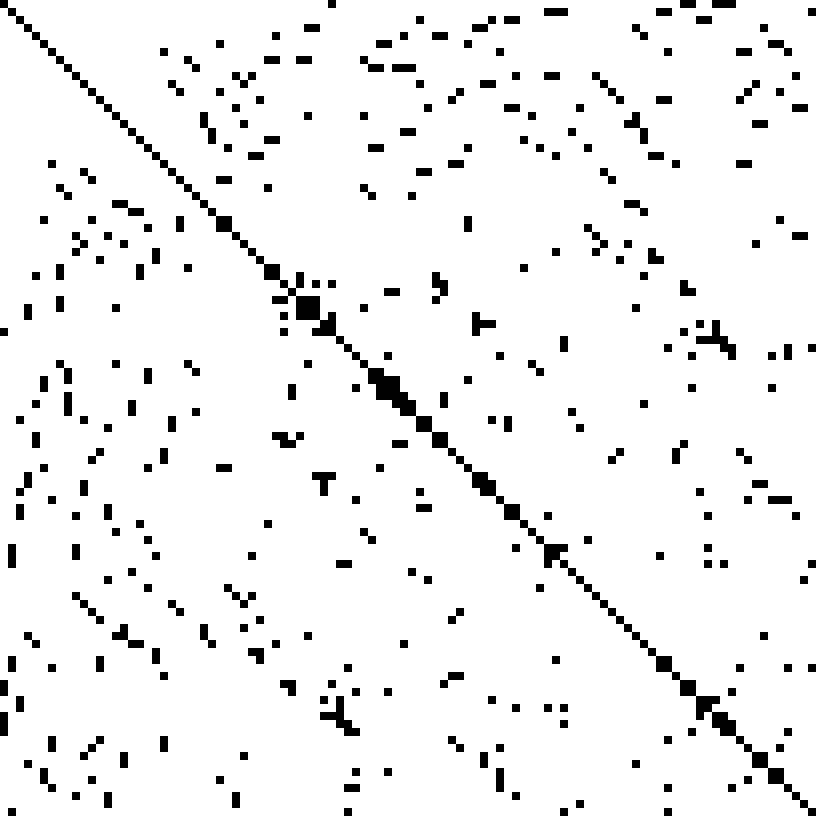

In [44]:
from IPython.display import Image

Image("../images/sparse_matrix.png", width=125)

### Constructing a sparse array

https://sparse.pydata.org/ provides a number of sparse array formats. Here we work with `sparse.COO`.

We construct a `sparse.COO` array by passing a list of non-zero data values and the coordinate locations for those values

In [2]:
# in this case shape=(3,3), dtype=np.int64, and fill_value=0 are set by default
eye = sparse.COO(coords=[[0, 1, 2], [0, 1, 2]], data=[1, 1, 1])
eye

Format,coo
Data Type,int64
Shape,"(3, 3)"
nnz,3
Density,0.3333333333333333
Read-only,True
Size,72
Storage ratio,1.0


To convert to a dense NumPy array use `.todense`

In [3]:
eye.todense()  # identity matrix!

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

A slightly more complicated example, with a bigger `shape`, and a custom `fill_value`

In [4]:
array = sparse.COO(
    coords=[[0, 1, 2], [0, 1, 2]],
    data=np.array([1, 1, 1], dtype=np.float32),
    shape=(4, 4),
    fill_value=np.nan,
)
array

Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.9


In [5]:
array.todense()

array([[ 1., nan, nan, nan],
       [nan,  1., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan, nan, nan]], dtype=float32)

### Sparse arrays with dask

The idea here is that each dask block is a sparse array (compare the more common case where each block is a NumPy array). This works well, dask recognizes that the chunks are sparse arrays (see Type under Chunk)

In [6]:
import dask.array

dasky_array = dask.array.from_array(array, chunks=2)
dasky_array

dask.array<array, shape=(4, 4), dtype=float32, chunksize=(2, 2), chunktype=sparse.COO>

## Wrapping sparse arrays in xarray

works

In [7]:
da = xr.DataArray(array, coords={"x": np.arange(4), "y": np.arange(4)})
da

Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.9


Access the underlying sparse array using `DataArray.data`

In [8]:
da.data

Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.9


Convert to NumPy using `DataArray.as_numpy`

In [9]:
da.as_numpy()

<xarray.DataArray (x: 4, y: 4)>
array([[ 1., nan, nan, nan],
       [nan,  1., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) int64 0 1 2 3
  * y        (y) int64 0 1 2 3

Convert and extract the numpy array using `DataArray.to_numpy`

In [10]:
da.to_numpy()

array([[ 1., nan, nan, nan],
       [nan,  1., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan, nan, nan]], dtype=float32)

Plotting works easily (the array is "densified", or converted to a NumPy array, automatically before being passed to matplotlib)

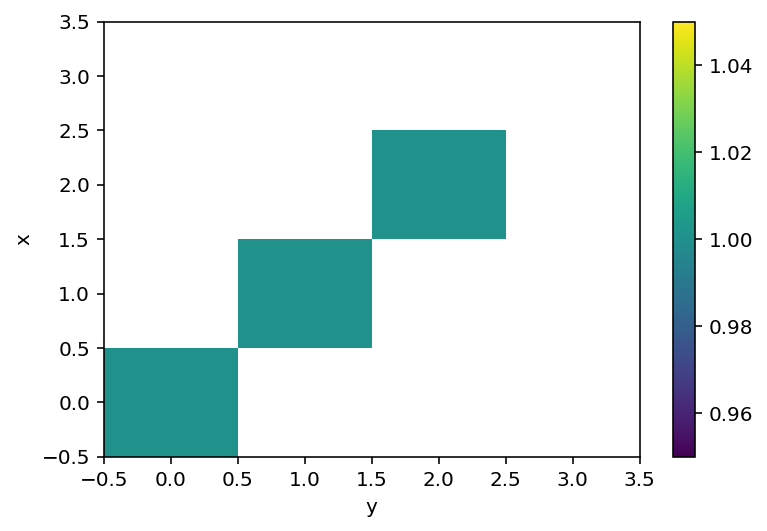

In [11]:
da.plot()

This works.

In [12]:
da.mean("x")

Format,coo
Data Type,float64
Shape,"(4,)"
nnz,3
Density,0.75
Read-only,True
Size,48
Storage ratio,1.5


### Sparse arrays with dask + xarray

Xarray knows how to handle dask arrays, so we can just pass `dasky_array` and things work

In [13]:
xr.DataArray(dasky_array, coords={"x": [1, 2, 3, 4], "y": [1, 2, 3, 4]})

<xarray.DataArray 'array-8e28f4e6653ecaa445c49b8638c8f808' (x: 4, y: 4)>
dask.array<array, shape=(4, 4), dtype=float32, chunksize=(2, 2), chunktype=sparse.COO>
Coordinates:
  * x        (x) int64 1 2 3 4
  * y        (y) int64 1 2 3 4

## Land model output

Lets read a dataset.

This dataset represents output from the Community Land Model (CLM), the land model component of CESM. The particular variable here is gross primary production (GPP), which is essentially photosynthesis or carbon uptake by plants. Because CLM represents different [plant functional types (PFTs)](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Crop_Irrigation/CLM50_Tech_Note_Crop_Irrigation.html#crop-plant-functional-types) within a single model grid cell (up to 78 different types including natural vegetation and crops), this dataset includes information on how GPP varies by PFT. This way we can examine photosynthesis and how it varies across different plant types. To visualize this output, we often need to remap the information to a latitude/longitude grid, preserving plant type.

In [14]:
data = xr.open_dataset(
    "/glade/p/cgd/tss/people/dll/TRENDY2019_History/S0_control/TRENDY2019_S0_control_v2.clm2.h1.GPP.170001-201812.nc",
    decode_times=True,
    chunks={"time": 100},
)
data

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288, lat: 192, gridcell: 21013, landunit: 48359, column: 111429, pft: 166408, time: 3828, hist_interval: 2)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * lon                 (lon) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lat                 (lat) float32 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * time                (time) object 1700-02-01 00:00:00 ... 2019-01-01 00:0...
Dimensions without coordinates: gridcell, landunit, column, pft, hist_interval
Data variables: (12/51)
    area                (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac            (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask            (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask             (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock            (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    grid1d_lon          (gridcell) float64 dask.array<chunksize=(21013,), meta=np.ndarray>
    ...                  ...
    mscur               (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    nstep               (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    time_bounds         (time, hist_interval) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    date_written        (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    time_written        (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    GPP                 (time, pft) float32 dask.array<chunksize=(100, 166408), meta=np.ndarray>
Attributes: (12/102)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/27/19 16:25:57
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./TRENDY2019_S0_constant_v2.cl...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

The `GPP` DataArray has 2 dimensions: `time` and `pft` where `pft` is really a compressed dimension representing 3 more dimensions in the data (`lon`, `lat`, and `type` of sizes 288, 192, and 78 respectively)

**Needs more  on data layout here**

In [15]:
data.GPP

<xarray.DataArray 'GPP' (time: 3828, pft: 166408)>
dask.array<open_dataset-e503263520abd161067be1f5e311c2e1GPP, shape=(3828, 166408), dtype=float32, chunksize=(100, 166408), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1700-02-01 00:00:00 ... 2019-01-01 00:00:00
Dimensions without coordinates: pft
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

**Goal** Our goal here is to expand this 2D dataarray to a 4D sparse array (`time`, `type`, `lat`, `lon`), so no extra memory is used but we get to work with a substantially simpler representation of the dataset

### Convert a single timestep to sparse

Lets begin with a simple subset of the problem: a single timestep as a numpy array.

In [16]:
subset = data.GPP.isel(time=0).load()
subset

<xarray.DataArray 'GPP' (pft: 166408)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    time     object 1700-02-01 00:00:00
Dimensions without coordinates: pft
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

Recall that for `sparse.COO` we need to provide the data (here `subset`) and coordinate locations.

These coordinate locations are available as `pfts1d_ixy` and `pfts1d_jxy`. For some reason these integers are stored as floating point, but sparse expects integers, so we will convert the dtype. Since sparse needs to know the data locations, we must load the values i.e. we cannot pass a dask array to `sparse.COO`

In [17]:
ixy = data.pfts1d_ixy.load().astype(int)
jxy = data.pfts1d_jxy.load().astype(int)
vegtype = data.pfts1d_itype_veg.load().astype(int)
vegtype

<xarray.DataArray 'pfts1d_itype_veg' (pft: 166408)>
array([0, 0, 0, ..., 0, 0, 0])
Dimensions without coordinates: pft
Attributes:
    long_name:  pft vegetation type

In [18]:
ixy

<xarray.DataArray 'pfts1d_ixy' (pft: 166408)>
array([  1,   1,   2, ..., 265, 265, 265])
Dimensions without coordinates: pft
Attributes:
    long_name:  2d longitude index of corresponding pft

We construct the coordinate locations by first subtracting 1 from `ixy` and `jxy` (since that's what sparse expects) and stacking all coordinate arrays together along `axis=0`

In [19]:
coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
coords.shape

(3, 166408)

In [20]:
sparse.COO(coords=coords, data=subset.data)

Format,coo
Data Type,float32
Shape,"(78, 186, 288)"
nnz,104414
Density,0.024989565144135036
Read-only,True
Size,2.8M
Storage ratio,0.2


Note that the shape is (78, **186**, 288). The `lat` dimension is sized 186 but `data.lat` has 192 elements.

We'll fix this by specifying `shape` manually

In [21]:
sparse_gpp = sparse.COO(
    coords=coords,
    data=subset.data,
    shape=(np.max(vegtype.data) + 1, data.sizes["lat"], data.sizes["lon"]),
    fill_value=np.nan,
)
sparse_gpp

Format,coo
Data Type,float32
Shape,"(78, 192, 288)"
nnz,104414
Density,0.024208641233380818
Read-only,True
Size,2.8M
Storage ratio,0.2


And put it all together to construct a DataArray

In [22]:
sparse_gpp_da = xr.DataArray(
    sparse_gpp,
    dims=("type", "lat", "lon"),
    coords={"lat": data.lat, "lon": data.lon},
)
sparse_gpp_da

Format,coo
Data Type,float32
Shape,"(78, 192, 288)"
nnz,104414
Density,0.024208641233380818
Read-only,True
Size,2.8M
Storage ratio,0.2


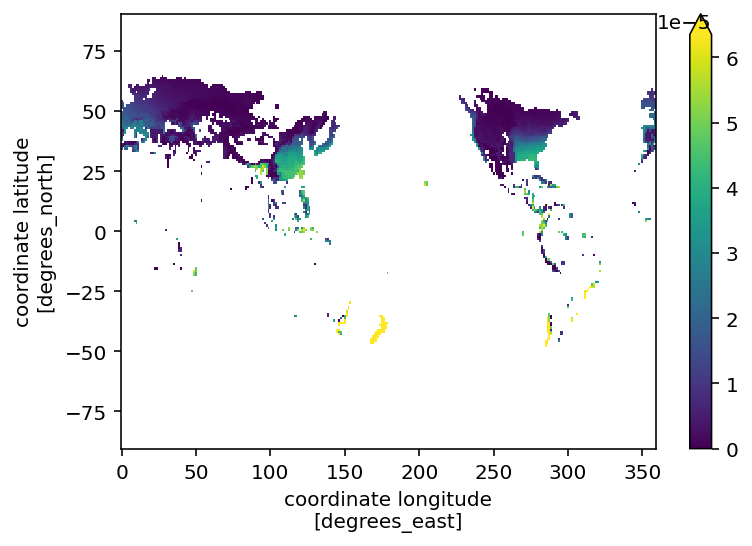

In [23]:
sparse_gpp_da.sel(type=1).plot(robust=True)

#### Aside: further compressing the `vegtype` dimension

The `vegtype` dimension is sized `78` because `max(vegtype)` is 77. However there are substantially fewer `vegtypes`. 

In [24]:
len(np.unique(vegtype))

23

We could convert the vegtype array to integer codes to save more memory upon densifying using `np.unique`

In [25]:
types, vegcodes = np.unique(vegtype, return_inverse=True)
# verify that codes are correct
np.testing.assert_equal(types[vegcodes], vegtype)
print(types, vegcodes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 19 23 41 61 67 75 77] [0 0 0 ... 0 0 0]


In [26]:
coords = np.stack([vegcodes, jxy - 1, ixy - 1], axis=0)
sparse_gpp = sparse.COO(
    coords=coords,
    data=subset.data,
    shape=(len(types), data.sizes["lat"], data.sizes["lon"]),
    fill_value=np.nan,
)
sparse_gpp

Format,coo
Data Type,float32
Shape,"(23, 192, 288)"
nnz,104414
Density,0.08209887026972625
Read-only,True
Size,2.8M
Storage ratio,0.6


### Convert multiple timesteps to sparse

Our chunks are `100` in time, that means we need to do some extra work to convert each chunk  to a sparse array in one go. We'll also anticipate converting dataarrays using `xarray.apply_ufunc` and so make functions that take  numpy arrays as input

We could loop over time and concatenate them, but it should be faster to construct the appropriate `coords` array for coordinate locations and pass all of the data at once

In [27]:
data.GPP

<xarray.DataArray 'GPP' (time: 3828, pft: 166408)>
dask.array<open_dataset-e503263520abd161067be1f5e311c2e1GPP, shape=(3828, 166408), dtype=float32, chunksize=(100, 166408), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1700-02-01 00:00:00 ... 2019-01-01 00:00:00
Dimensions without coordinates: pft
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

Lets again extract a small subset

In [28]:
subset = data.GPP.isel(time=slice(4)).load()
subset

<xarray.DataArray 'GPP' (time: 4, pft: 166408)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * time     (time) object 1700-02-01 00:00:00 ... 1700-05-01 00:00:00
Dimensions without coordinates: pft
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

sparse expects:
> `coords (numpy.ndarray (COO.ndim, COO.nnz))` – An 2D array holding the index locations of every value Should have shape (number of dimensions, number of non-zeros).
> `data (numpy.ndarray (COO.nnz,))` – A 1D array of Values.

Since `data` should be 1D we pass `data=subset.ravel()` and construct the appropriate 2D `coords` array. This is a bit annoying but here's the solution.

In [29]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


# note vegcodes is already a numpy array
# we use .data to extract the underlying array from DataArrays  subset, vegtype, jxy, ixy
sparse_gpp = to_sparse(subset.data, vegtype.data, jxy.data, ixy.data, shape=(78, 192, 288))
sparse_gpp

Format,coo
Data Type,float32
Shape,"(4, 78, 192, 288)"
nnz,417656
Density,0.024208641233380818
Read-only,True
Size,14.3M
Storage ratio,0.2


In [30]:
sparse_gpp_da = xr.DataArray(
    sparse_gpp,
    dims=("time", "type", "lat", "lon"),
    coords={"time": subset.time, "lat": data.lat, "lon": data.lon},
)
sparse_gpp_da

Format,coo
Data Type,float32
Shape,"(4, 78, 192, 288)"
nnz,417656
Density,0.024208641233380818
Read-only,True
Size,14.3M
Storage ratio,0.2


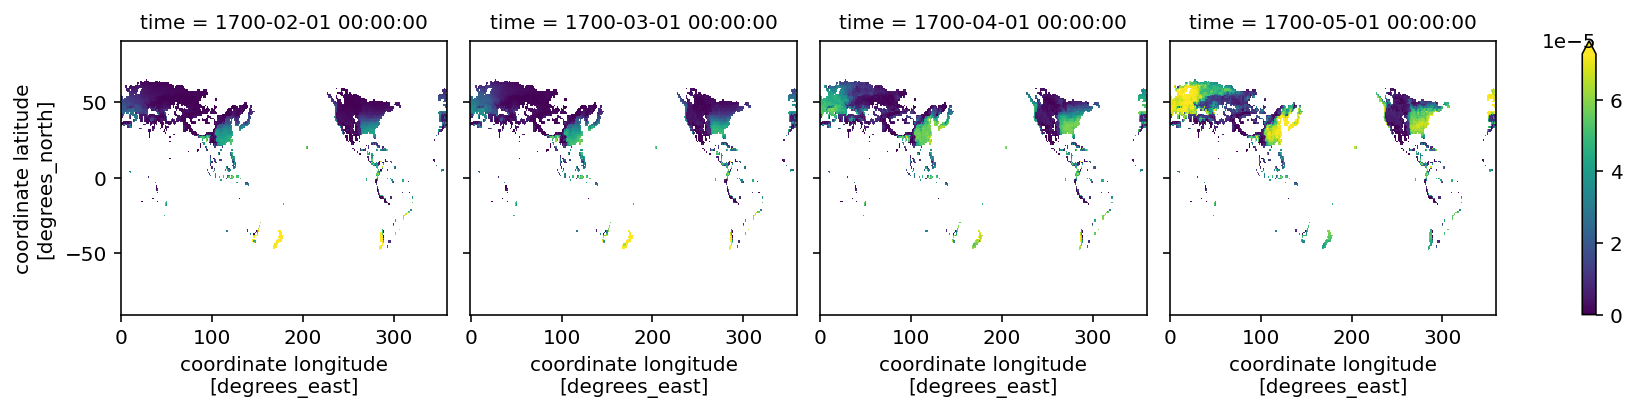

In [31]:
sparse_gpp_da.sel(type=1).plot(col="time", robust=True)

### Using `xarray.apply_ufunc`

We extracted numpy arrays, called `to_sparse` and then used the returned `sparse.COO` array to manually create a DataArray. Now we wrap those steps using `xarray.apply_ufunc`.  Why so?

1. `apply_ufunc` is really useful when you want to apply a function that expects and returns pure arrays (like numpy or sparse.COO) to an xarray object.

2. We also anticipate using it's [automatic parallelization](https://docs.xarray.dev/en/stable/user-guide/dask.html#automatic-parallelization-with-apply-ufunc-and-map-blocks) capabilities with dask.

We specify `pft` as the "input core dimension" since our function `to_sparse` expects this as the last dimension. `apply_ufunc` will automatically transpose inputs to make `pft` the  last dimension. One clue that `pft` is the core dimension is that the smallest unit of data `to_sparse` can process is 1D along the `pft` dimension.

We start with this

which fails with


Xarray complains because it received a 4D variable back `(time, type, lat, lon)` but only knows about the `time` dimension. We need to specify the rest using `output_core_dims`.

In [32]:
xr.apply_ufunc(
    # function to apply
    to_sparse,
    # array inputs expected by to_sparse
    subset,
    vegcodes,
    jxy,
    ixy,
    # other non-array arguments expected by to_sparse
    kwargs={"shape": (78, 192, 288)},
    # extra metadata info required by apply_ufunc
    input_core_dims=[["pft"], ["pft"], ["pft"], ["pft"]],
    output_core_dims=[["type", "lat", "lon"]],
)

Format,coo
Data Type,float32
Shape,"(4, 78, 192, 288)"
nnz,417656
Density,0.024208641233380818
Read-only,True
Size,14.3M
Storage ratio,0.2


### Apply to entire dask DataArray

Now we use `xr.apply_ufunc` to convert all of the data to sparse with `to_sparse`. This transformation can be applied  to each block of a dask array independently, so we can use `dask="parallelized"` to automatically parallelize the operation (using something like `dask.array.map_blocks` underneath).

Dask will also need us to provide the sizes for these new dimensions.

In [33]:
xr.apply_ufunc(
    # function to apply
    to_sparse,
    # array inputs expected by to_sparse
    data.GPP,
    vegcodes,
    jxy,
    ixy,
    # other non-array arguments expected by to_sparse
    kwargs={"shape": (78, 192, 288)},
    # extra metadata info required by apply_ufunc
    input_core_dims=[["pft"], ["pft"], ["pft"], ["pft"]],
    output_core_dims=[["type", "lat", "lon"]],
    dask="parallelized",
    # info needed by dask to automatically parallelize with dask.array.apply_gufunc
    dask_gufunc_kwargs=dict(
        output_sizes={"type": 23, "lat": 192, "lon": 288},
    ),
)

,Array,Chunk
Bytes,18.14 GiB,485.16 MiB
Shape,"(3828, 23, 192, 288)","(100, 23, 192, 288)"
Count,160 Tasks,39 Chunks
Type,float32,numpy.ndarray


This looks better but notice that dask still thinks its working with numpy arrays (see Type under Chunk). We need to tell dask that the output of  `to_sparse` is a sparse array. (dask tries to detect such things automatically but for some reason that is failing).

We do that by passing the `meta` parameter which is an empty array with the right array type (`sparse.COO`) and right dtype.

In [34]:
xr.apply_ufunc(
    # function to apply
    to_sparse,
    # array inputs expected by to_sparse
    data.GPP,
    vegcodes,
    jxy,
    ixy,
    # other non-array arguments expected by to_sparse
    kwargs={"shape": (78, 192, 288)},
    # extra metadata info required by apply_ufunc
    input_core_dims=[["pft"], ["pft"], ["pft"], ["pft"]],
    output_core_dims=[["type", "lat", "lon"]],
    dask="parallelized",
    # info needed by dask to automatically parallelize with dask.array.apply_gufunc
    dask_gufunc_kwargs=dict(
        meta=sparse.COO(np.array([], dtype=data.GPP.dtype)),
        output_sizes={"type": 23, "lat": 192, "lon": 288},
    ),
)

,Array,Chunk
Shape,"(3828, 23, 192, 288)","(100, 23, 192, 288)"
Count,160 Tasks,39 Chunks
Type,float32,sparse._coo.core.COO


This looks right!

## Putting it all together

Here's a generalized  function that 
1. Takes a Dataset like `data` as input
1. Extracts all  variables with the  `"pft"` dimension
1. Converts to sparse arrays detecting appropriate dimension sizes
1. Returns a new Dataset with only `pft` variables as sparse arrays

In [35]:
def convert_pft_variables_to_sparse(dataset):
    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = np.max(vegtype.data) + 1
    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "type": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["type", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result.attrs = dataset.attrs
    return result

In [36]:
pfts = convert_pft_variables_to_sparse(data)
pfts

<xarray.Dataset>
Dimensions:             (lat: 192, lon: 288, type: 78, time: 3828)
Coordinates:
  * lat                 (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                 (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time                (time) object 1700-02-01 00:00:00 ... 2019-01-01 00:0...
Dimensions without coordinates: type
Data variables: (12/15)
    pfts1d_lon          (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_lat          (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_ixy          (type, lat, lon) float64 <COO: nnz=104414, fill_value=nan>
    pfts1d_jxy          (type, lat, lon) float64 <COO: nnz=104414, fill_value=nan>
    pfts1d_gi           (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_li           (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    ...                  ...
    pfts1d_wtcol        (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_veg    (type, lat, lon) float64 <COO: nnz=104414, fill_value=nan>
    pfts1d_itype_col    (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_itype_lunit  (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    pfts1d_active       (type, lat, lon) float64 dask.array<chunksize=(78, 192, 288), meta=np.ndarray>
    GPP                 (time, type, lat, lon) float32 dask.array<chunksize=(100, 78, 192, 288), meta=sparse.COO>
Attributes: (12/102)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/27/19 16:25:57
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./TRENDY2019_S0_constant_v2.cl...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Make a test plot

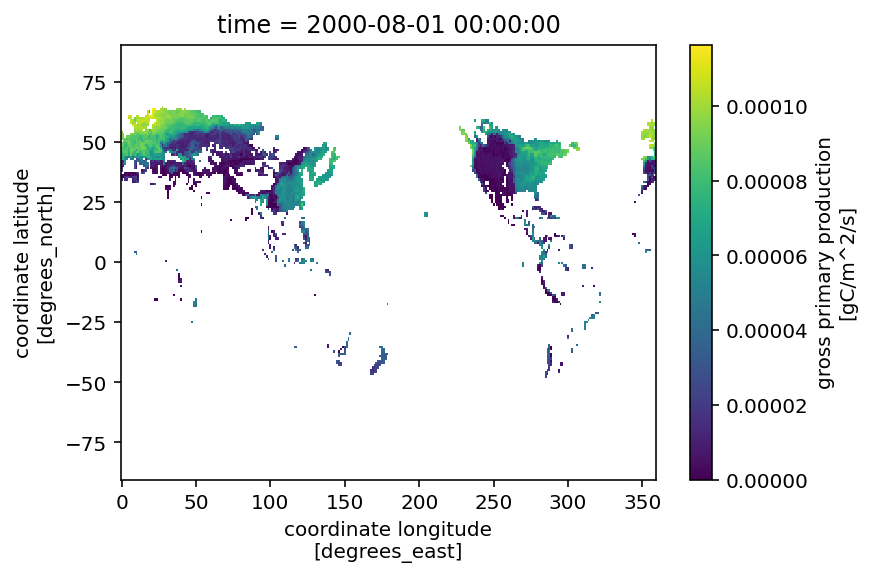

In [37]:
pfts.GPP.isel(type=1, time=3606).plot()

## Summary

1. We first developed a function `to_sparse` that took as input 1D or 2D compressed NumPy arrays and converted them to `sparse.COO` arrays. 
1. We then used `apply_ufunc` to apply `to_sparse` to xarray inputs, and receive an xarray object in return.
1. We automatically parallelized applying `to_sparse` to every dask block by specifying `dask="parallelized"` in the `apply_ufunc` call.
1. Finally we wrote a function `convert_pfts_to_sparse` that takes an xarray Dataset as input, converts the dense 2D NumPy arrays read from disk to a 4D sparse array, and returns back a new Dataset

## Question

1. Are there places where sparse arrays could help in your analysis?
   - Start a thread on Zulip!
2. CF conventions for representing sparse data arrays exist: for example ["compression by gathering"](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html#compression-by-gathering). If the model output satisfied these conventions, we could write "encoder" and "decoder" [functions](https://github.com/pydata/xarray/issues/1077#issuecomment-644442679) that converted these arrays to sparse arrays in the `open_dataset`/`to_netcdf`/`to_zarr` functions. Is anyone interested in pursuing this?